In [1]:
import os
import pathlib

ROOT_PATH = pathlib.Path(__name__).resolve().parent.parent
print(ROOT_PATH)
RANDOM_SEED = 42

/Users/andrey/PycharmProjects/vector-search-hse


In [2]:
os.chdir(ROOT_PATH)
os.getcwd()

'/Users/andrey/PycharmProjects/vector-search-hse'

In [15]:
from vs._local.storage import LocalVideoInfoStorage

FILE_NAME = ROOT_PATH / "video.json"
storage = LocalVideoInfoStorage.from_file(FILE_NAME)

# Qdrant Create Collection

In [16]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

client = QdrantClient("http://localhost:6333")

In [17]:
COLLECTION_NAME = "tiktok_vectors"

client.delete_collection(COLLECTION_NAME)


if not client.collection_exists(COLLECTION_NAME):
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(
            size=512,
            on_disk=True,
            distance=Distance.COSINE,
        ),
        on_disk_payload=True,
    )

# Embed Video Frames and Upload to Db

In [18]:
from fastembed import ImageEmbedding, TextEmbedding

img_embedder = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")
txt_embedder = TextEmbedding(model_name="Qdrant/clip-ViT-B-32-text")

In [19]:
from qdrant_client import models
from tqdm import tqdm

for video in tqdm(storage.videos[:40]):
    image_paths = [img.path for img in video.frames]
    embeddings = img_embedder.embed(image_paths)

    points = [
        models.PointStruct(
            # По id векторы не дублируются
            id=image.id,
            vector=vector,
            payload={
                "image_path": image.path,
                "video_path": video.video_path,
                "video_id": video.id,
            },
        )
        for vector, image in zip(embeddings, video.frames)
    ]
    client.upsert(
        collection_name=COLLECTION_NAME,
        points=points,
    )

100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


# Qdrant Base Search

In [25]:
import numpy as np

def get_text_embedding(text: str) -> np.ndarray:
    return list(txt_embedder.embed(text))[0]

In [26]:
from qdrant_client.models import ScoredPoint


def query_vectors(query: str, n_limit: int = 10) -> list[ScoredPoint]:
    vector = get_text_embedding(query)

    result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=vector,
        limit=n_limit,
        with_vectors=False,  # True if want to see vector
    )
    return result.points


points = query_vectors("aircraft", n_limit=50)
points[:5]

[ScoredPoint(id='9e1c5d30-0537-42dd-8e37-d70a665d2ece', version=5, score=0.276908, payload={'image_path': 'frames/d7d1e4e6ad0540269183d9a266de63a1/000360.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'd7d1e4e6ad0540269183d9a266de63a1'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='f9cc6e8b-b029-4f64-b9af-dc4144757eea', version=5, score=0.2758844, payload={'image_path': 'frames/d7d1e4e6ad0540269183d9a266de63a1/000090.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'd7d1e4e6ad0540269183d9a266de63a1'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='e4736a29-070a-422c-a1ec-2ac15c341f2f', version=5, score=0.2608048, payload={'image_path': 'frames/d7d1e4e6ad0540269183d9a266de63a1/000300.png', 'video_path': 'data/video/IMG_1348.MOV', 'video_id': 'd7d1e4e6ad0540269183d9a266de63a1'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id='8c34c2fc-abd7-4383-a9a0-60c368e2b1fa', version=5, score=0.2589762, payload={'image_path

In [27]:
from typing import Any


def get_per_video_results(
    points: list[models.ScoredPoint],
) -> dict[str, Any]:
    """Compute per video results."""

    uniq_videos = {point.payload.get("video_id") for point in points}

    data = {
        video_id: {"id": video_id, "n_freq": 0, "avg_sim": 0, "images": []}
        for video_id in uniq_videos
    }

    for point in points:
        payload = point.payload
        video_id = payload.get("video_id")
        data[video_id]["n_freq"] += 1
        data[video_id]["images"].append(
            {"id": point.id, "image": payload.get("image_path"), "score": point.score}
        )

    scored_data = sorted(
        list(data.values()), key=lambda x: x.get("n_freq"), reverse=True
    )

    return [score_obj for score_obj in scored_data if score_obj["n_freq"] > 4]


stat_data = get_per_video_results(points)
stat_data

[{'id': '92623ecdcdb44fc8a7bbbe05a6007140',
  'n_freq': 17,
  'avg_sim': 0,
  'images': [{'id': 'ab7f391d-05df-472f-8142-2f6a55290474',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/010920.png',
    'score': 0.2540516},
   {'id': 'af33d7c2-4cf1-4246-918e-a8be2a39f8a9',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/004584.png',
    'score': 0.24448107},
   {'id': '9fd3f3e5-6f21-436b-841c-365479742ed8',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/001272.png',
    'score': 0.24372141},
   {'id': '9bccb66c-74f2-4fcf-a249-c21909b82c11',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/007800.png',
    'score': 0.24163356},
   {'id': 'e2eb71bf-6bf1-413a-90c0-73161c101dbb',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/001248.png',
    'score': 0.23478746},
   {'id': 'feec9b92-4454-4c3a-8546-1d4b4d635806',
    'image': 'frames/92623ecdcdb44fc8a7bbbe05a6007140/010320.png',
    'score': 0.23193972},
   {'id': '8218a0f0-db7b-429b-8a51-ac6d45b91b8e',
    'im

In [28]:
from matplotlib import pyplot as plt
from PIL import Image


def plot_images_with_scores(
    video_name: str,
    images: list,
):
    plt.figure(figsize=(7, 7))
    plt.suptitle("Video {}".format(video_name))
    plt.tight_layout()
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.title(images[i].get("score"))
        plt.axis("off")
        # plt.subtitle(scores[i])
        plt.imshow(Image.open(images[i].get("image")))
    plt.show()
    plt.close()

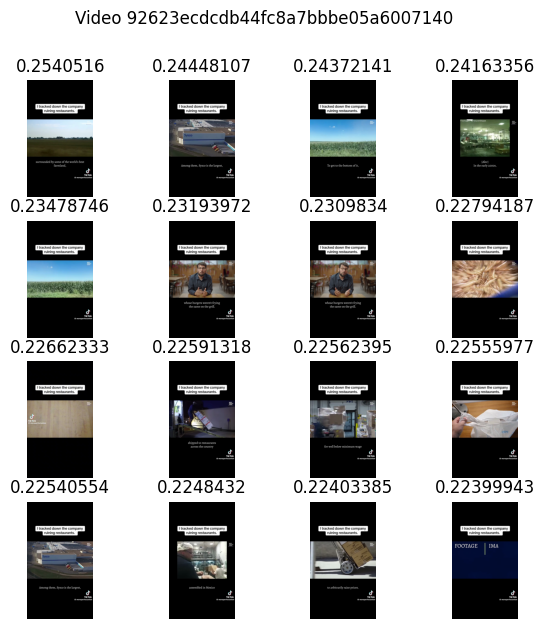

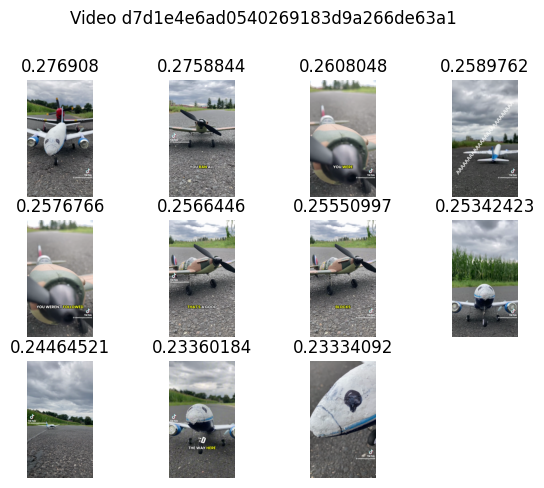

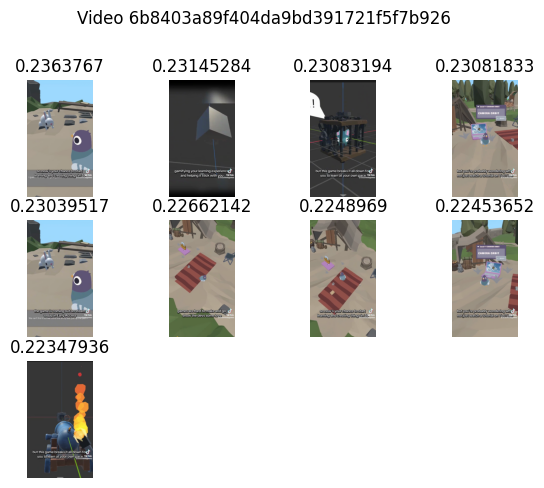

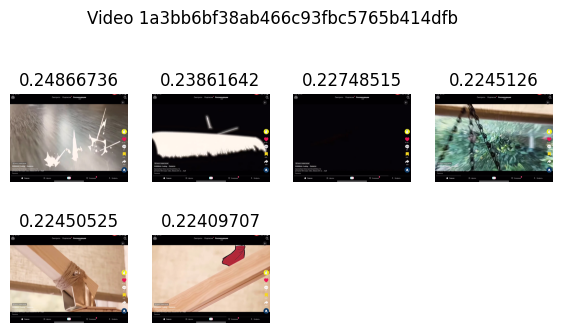

In [29]:
for stat in stat_data:
    video_info = storage.get_video_info_by_id(video_id=stat["id"])
    images = stat.get("images", [])

    plot_images_with_scores(
        video_name=video_info.id,
        images=images,
    )